In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
from fee_algorithm.fixed_fee import FixedFee
from prices_snapshot import PricesSnapshot
from visualizations.utility import get_initial_pool_sizes
from pool.liquidity_state import PoolLiquidityState

In [3]:
prices = PricesSnapshot(
    price_a=69989, # ETH
    price_b=2518, # BTC
)

initial_quantity_a, initial_quantity_b = get_initial_pool_sizes(prices.price_a, prices.price_b, total_pool=10000)

print(f"Initial fair pool sizes: {initial_quantity_a}, {initial_quantity_b}")

fair_pool_state = PoolLiquidityState(
    quantity_a=initial_quantity_a,
    quantity_b=initial_quantity_b,
)

current_pool_state = PoolLiquidityState(
    quantity_a=initial_quantity_a - 100,
    quantity_b=initial_quantity_b,
)

print(f"Fair pool state: {fair_pool_state}")
print(f"Current pool state: {current_pool_state}")

Initial fair pool sizes: 347.2768146523784, 9652.723185347622
Fair pool state: PoolLiquidityState(quantity_a=347.2768146523784, quantity_b=9652.723185347622)
Current pool state: PoolLiquidityState(quantity_a=247.2768146523784, quantity_b=9652.723185347622)


In [4]:
print(f"A -> B price according to the pool: {current_pool_state.get_a_to_b_exchange_price()}")
print(f"Fair A -> B price: {prices.get_a_to_b_price()}")

A -> B price according to the pool: 39.0361029153397
Fair A -> B price: 27.795472597299444


In [5]:
fixed_fee = FixedFee(0.003)
continuous_fee_based_on_trade = ContinuousFeePerfectOracle(default_fee_rate=0.003)

continuous_fee_based_on_trade.process_oracle_price(prices.get_a_to_b_price())

In [6]:
from fee_algorithm.punish_price_move_relative_to_ema import PunishPriceMoveRelativeToEmaIncludingCurrentTradeFee

fee_punish_price_move_relative_to_ema = PunishPriceMoveRelativeToEmaIncludingCurrentTradeFee(
    decay=0.99,
    base_fee=0.003,
)

fee_punish_price_move_relative_to_ema.process_initial_pool_state(fair_pool_state)

In [7]:
import numpy as np

res = []

for x_user in np.linspace(0, 200, 100):
    fixed_fee_paid = fixed_fee.get_a_to_b_trade_fee(current_pool_state, x_user)
    fee_continuous_based_on_perfect_oracle_paid = continuous_fee_based_on_trade.get_a_to_b_trade_fee(current_pool_state, x_user)
    fee_punish_price_move_relative_to_ema_paid = fee_punish_price_move_relative_to_ema.get_a_to_b_trade_fee(current_pool_state, x_user)

    res.append(
        {
            "x_user": x_user,
            "fee_fixed": fixed_fee_paid,
            "fee_continuous_based_on_perfect_oracle": fee_continuous_based_on_perfect_oracle_paid,
            "fee_punish_price_move_relative_to_ema": fee_punish_price_move_relative_to_ema_paid,
        }
    )

In [8]:
from user.informed_user import InformedUser
from pool.pool import Pool

fixed_fee_pool = Pool(
    liquidity_state=current_pool_state,
    fee_algorithm=fixed_fee,
)

optimal_action_with_fixed_fee = InformedUser().get_user_action(pool=fixed_fee_pool, network_fee=0, prices=prices)


print(f"Optimal action with fixed fee: {optimal_action_with_fixed_fee}")
print(f"Pool delta: {optimal_action_with_fixed_fee.get_pool_balance_change()}")

Optimal action with fixed fee: UserAction(delta_x=np.float64(-45.46149055165133), delta_y=np.float64(1495.2420723747955), fee_x=np.float64(0.136384471654954), fee_y=0, network_fee=0)
Pool delta: BalanceChange(delta_x=np.float64(45.325106079996374), delta_y=np.float64(-1495.2420723747955))


In [9]:
from user.informed_user_bruteforce import InformedUserBruteforce

fee_continuous_based_on_perfect_oracle_pool = Pool(
    liquidity_state=current_pool_state,
    fee_algorithm=continuous_fee_based_on_trade,
)

optimal_action_with_fee_based_on_trade = InformedUserBruteforce(n_samples=10**5).get_user_action(pool=fee_continuous_based_on_perfect_oracle_pool, network_fee=0, prices=prices)

assert optimal_action_with_fee_based_on_trade is not None

print(f"Optimal action with continuous fee with perfect oracle: {optimal_action_with_fee_based_on_trade}")
print(f"Pool delta: {optimal_action_with_fee_based_on_trade.get_pool_balance_change()}")

Optimal action with continuous fee with perfect oracle: UserAction(delta_x=np.float64(-45.474660961181996), delta_y=np.float64(1494.9132815476896), fee_x=np.float64(0.16134785364572934), fee_y=0, network_fee=0)
Pool delta: BalanceChange(delta_x=np.float64(45.31331310753627), delta_y=np.float64(-1494.9132815476896))


In [10]:
fee_punish_price_move_relative_to_ema_pool = Pool(
    liquidity_state=current_pool_state,
    fee_algorithm=fee_punish_price_move_relative_to_ema,
)

optimal_action_with_fee_punish_price_move_relative_to_ema = InformedUserBruteforce(n_samples=10**5).get_user_action(pool=fee_punish_price_move_relative_to_ema_pool, network_fee=0, prices=prices)

assert optimal_action_with_fixed_fee is not None

print(f"Optimal action with fee punish price move relative to EMA: {optimal_action_with_fee_punish_price_move_relative_to_ema}")
print(f"Pool delta: {optimal_action_with_fee_punish_price_move_relative_to_ema.get_pool_balance_change()}")

Optimal action with fee punish price move relative to EMA: UserAction(delta_x=np.float64(-45.59830060490462), delta_y=np.float64(1499.0386620456075), fee_x=np.float64(0.136950667700196), fee_y=0, network_fee=0)
Pool delta: BalanceChange(delta_x=np.float64(45.461349937204425), delta_y=np.float64(-1499.0386620456075))


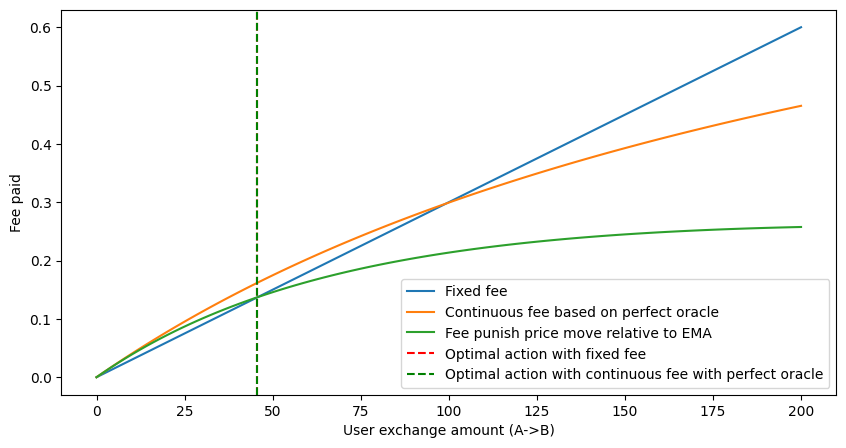

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res_pd = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=res_pd, x="x_user", y="fee_fixed", label="Fixed fee", ax=ax)
sns.lineplot(data=res_pd, x="x_user", y="fee_continuous_based_on_perfect_oracle", label="Continuous fee based on perfect oracle", ax=ax)
sns.lineplot(data=res_pd, x="x_user", y="fee_punish_price_move_relative_to_ema", label="Fee punish price move relative to EMA", ax=ax)

assert optimal_action_with_fixed_fee is not None
assert optimal_action_with_fee_based_on_trade is not None

ax.axvline(x=-optimal_action_with_fixed_fee.delta_x, color='red', linestyle='--', label='Optimal action with fixed fee')
ax.axvline(x=-optimal_action_with_fee_based_on_trade.delta_x, color='green', linestyle='--', label='Optimal action with continuous fee with perfect oracle')

plt.legend()

plt.xlabel("User exchange amount (A->B)")
plt.ylabel("Fee paid")


plt.show()